In [1]:
from __future__ import absolute_import, division, print_function
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from metric_utils import *

## Predictions Format

The model accepts predictions as JSON files in the following format
(The notation in caps with a dollar sign (`$IMG_NAME`) means that such key will be replaced by the actual value of the property)
```json
    {
        "$IMG_NAME": {
            "labels": [$CLASS_IDX: int, ..., $CLASS_IDX: int],
            "boxes": [[$X1, $X2, $Y1, $Y2], ..., [$X1, $X2, $Y1, $Y2]],
            "scores": [$CONFIDENCE_SCORE: float, ..., $CONFIDENCE_SCORE: float]
        },

        ...
        
        "$IMG_NAME": {
            "labels": [$CLASS_IDX: int, ..., $CLASS_IDX: int],
            "boxes": [[$X1, $X2, $Y1, $Y2], ..., [$X1, $X2, $Y1, $Y2]],
            "scores": [$CONFIDENCE_SCORE: float, ..., $CONFIDENCE_SCORE: float]
        }
    }
```

## Ground Truth Format

Compliant to [COCO format]()
```json
{
    "image": {
        "id": int, 
        "width": int, 
        "height": int, 
        "file_name": str
    },
    "annotations": {
        "id": int, 
        "image_id": int, 
        "category_id": int, 
        "segmentation": RLE or [polygon], 
        "area": float, 
        "bbox": [x,y,width,height], 
        "iscrowd": 0 or 1,
    },

    "categories": [{
        "id": int, 
        "name": str
    }]
}
```

## Visualization setup

In [2]:
sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

## Loading gt and pred annotations

In [6]:
with open('test.json') as infile:
    annotations = json.load(infile)

with open('rg-boxes.json') as infile:
    pred_boxes = json.load(infile)
    
id_to_filename = {}
for img in annotations['images']:
    id_to_filename[img['id']] = img['file_name'].split('.')[0]

class_id_to_name = {}
for cl in annotations['categories']:
    class_id_to_name[cl['id']] = cl['name']

gt_boxes = {}
for ann in annotations['annotations']:
    img_id = ann['image_id']
    img_name = id_to_filename[img_id]

    if img_name not in pred_boxes:
        print(f'Skipping {img_name} as there is no prediction associated')
        continue

    w, h = annotations['images'][img_id]['width'], annotations['images'][img_id]['height']

    if img_name not in gt_boxes:
        gt_boxes[img_name] = {'boxes': [], 'labels': []}
    bbox = ann['bbox'].copy()

    bbox[2] += bbox[0]
    bbox[3] += bbox[1]

    class_id = ann['category_id']
    gt_boxes[img_name]['boxes'].append(bbox)
    gt_boxes[img_name]['labels'].append(class_id)

Skipping sample4_galaxy1513 as there is no prediction associated
Skipping sample4_galaxy2361 as there is no prediction associated


In [7]:
# Split all groundtruths and detections into subsets by the object detected
for k, objs in gt_boxes.items():
    try:
        gt_boxes[k]['labels'] = [class_id_to_name[i] for i in objs['labels']]
    except Exception as e:
        print(f'Error for {k} in gt_boxes: {e.__class__} {e}')
        continue
    
for k, objs in pred_boxes.items():
    try:
        pred_boxes[k]['labels'] = [class_id_to_name[i] for i in objs['labels']]
    except Exception as e:
        print(f'Error for {k} in pred_boxes: {e.__class__} {e}')
        continue

gt_boxes_source, pred_boxes_source = split_boxes_by_class(gt_boxes, pred_boxes, 'source')
gt_boxes_sidelobe, pred_boxes_sidelobe = split_boxes_by_class(gt_boxes, pred_boxes, 'sidelobe')
gt_boxes_galaxy, pred_boxes_galaxy = split_boxes_by_class(gt_boxes, pred_boxes, 'galaxy')

## mAP@0.5

In [8]:
# Run per class mAP calculation for each class
iou_thr = 0.5
# calculate source mAP
data = get_avg_precision_at_iou(gt_boxes_source, pred_boxes_source, iou_thr=iou_thr)
print('Source avg precision: {:.4f}'.format(data['avg_prec']))
# calculate sidelobe mAP
data = get_avg_precision_at_iou(gt_boxes_sidelobe, pred_boxes_sidelobe, iou_thr=iou_thr)
print('Sidelobe avg precision: {:.4f}'.format(data['avg_prec']))
# calculate galaxy mAP
data = get_avg_precision_at_iou(gt_boxes_galaxy, pred_boxes_galaxy, iou_thr=iou_thr)
print('Galaxy avg precision: {:.4f}'.format(data['avg_prec']))

# Runs it for one IoU threshold for all predictions
start_time = time.time()
data = get_avg_precision_at_iou(gt_boxes, pred_boxes.copy(), iou_thr=iou_thr)
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))

Source avg precision: 0.7901
Sidelobe avg precision: 0.5356
Galaxy avg precision: 0.8688
Single IoU calculation took 2.8758 secs
avg precision: 0.7894


## mAP@0.5:0.95 + PR Curve

map: 50.01
avg precs:  [0.7894, 0.7813, 0.7676, 0.7472, 0.6548, 0.5446, 0.4121, 0.2312, 0.0501, 0.0227]
iou_thrs:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Plotting and calculating mAP takes 29.7692 secs


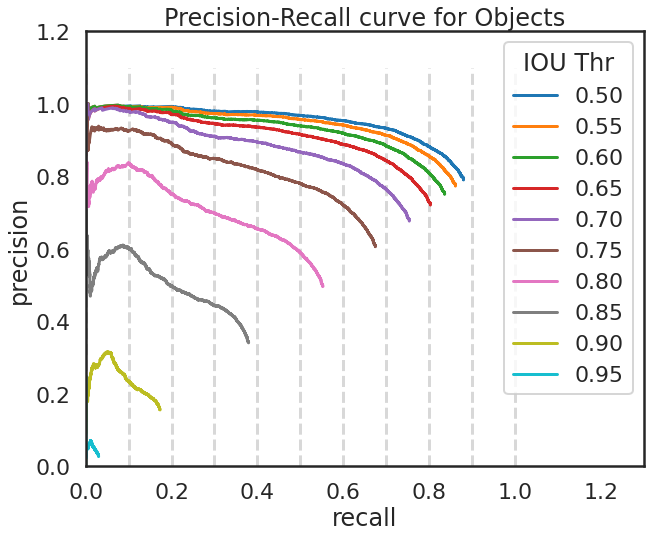

In [9]:
start_time = time.time()
ax = None
avg_precs = []
iou_thrs = []
for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    avg_precs.append(data['avg_prec'])
    iou_thrs.append(iou_thr)

    precisions = data['precisions']
    recalls = data['recalls']
    ax = plot_pr_curve(
        precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

# prettify for printing:
avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

## Plot PR Curve per class

map: 70.19
avg precs:  [0.7901, 0.7649, 0.5356, 0.4632, 0.8688, 0.7887]
iou_thrs:   [0.5, 0.6, 0.5, 0.6, 0.5, 0.6]

Plotting and calculating mAP takes 5.5023 secs


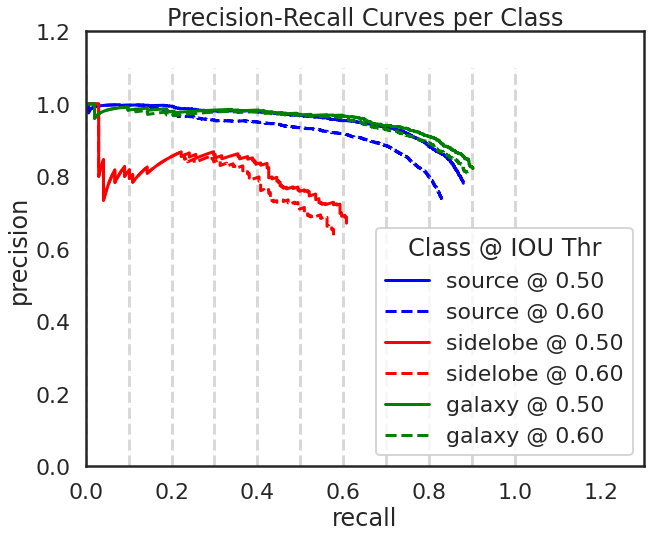

In [10]:
# Super-Imposed per Class
start_time = time.time()
ax = None
avg_precs = []
iou_thrs = []
classes = ['source', 'sidelobe', 'galaxy']
for i, classification in enumerate(classes):
    for iou_thr in np.linspace(0.5, 0.6, 2):
        if classification == 'source':
            data = get_avg_precision_at_iou(gt_boxes_source, pred_boxes_source, iou_thr=iou_thr)
            colour = 'blue'
        elif classification == 'sidelobe':
            data = get_avg_precision_at_iou(gt_boxes_sidelobe, pred_boxes_sidelobe, iou_thr=iou_thr)
            colour = 'red'
        elif classification == 'galaxy':
            data = get_avg_precision_at_iou(gt_boxes_galaxy, pred_boxes_galaxy, iou_thr=iou_thr)
            colour = 'green'
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)

        precisions = data['precisions']
        recalls = data['recalls']

        if iou_thr == 0.5:
            line_style = 'solid'
        elif iou_thr == 0.6:
            line_style = 'dashed'
        # ax = plot_pr_curve(precisions, recalls, label=classification+' @ {:.2f}'.format(iou_thr),
        #                    color=COLORS[i*len(classes) + j], ax=ax)
        ax = plot_pr_curve(precisions, recalls, label=classification + ' @ {:.2f}'.format(iou_thr),
                            color=colour, ax=ax, linestyle=line_style)


# prettify for printing:
avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100 * np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.title('Precision-Recall Curves per Class')
plt.legend(loc='lower right', title='Class @ IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()